In [ ]:
testDict = {
    '0-16km': (0, loc_conversion(16000))
}

# Iterate through the files in the folder
for filename in tqdm(os.listdir(folderpath), desc="Files"):
    if filename.endswith('.json'):
        json_path = os.path.join(folderpath, filename)

        # Read JSON file
        with open(json_path, 'r') as json_file:
            json_data = json.load(json_file)

        # Convert data to a flat list of dictionaries
        flat_data = []
        for frame_key, frame_data in json_data.items():
            for vehicle in frame_data:
                flat_data.append({
                    'frame': int(frame_key),
                    'uuid': vehicle['uuid'],
                    'vehicle_type': vehicle['vehicle_type'],
                    'location': vehicle['location'],
                    'speed': vehicle['speed'],
                    'timestamp': vehicle['timestamp']
                })
        # Create a DataFrame from the flat data
        df = pd.DataFrame(flat_data)

        # Create a list to store interval-specific DataFrames
        interval_dfs = []

        # Filter rows and create interval-specific DataFrames
        for label, (start, end) in testDict.items():
            interval_rows = df[df['location'].apply(lambda x: start <= x[0] <= end)]
            interval_rows['Interval'] = label  # Add a new column for interval label
            interval_dfs.append(interval_rows)

        # Combine interval-specific DataFrames into a single DataFrame
        combined_df = pd.concat(interval_dfs, ignore_index=True)

        # Convert speed from pixel/second -> kmph
        combined_df['speed'] *= (3600 / 2000)

        # Group by interval and frame, and calculate necessary statistics
        grouped_df = combined_df.groupby(['Interval', 'frame']).agg({
            'speed': 'mean',
            'uuid': 'nunique'
        }).reset_index()

        # Rename columns for clarity
        grouped_df.rename(columns={'speed': 'average_speed', 'uuid': 'num_vehicles'}, inplace=True)

        # Compute flow and moving average
        grouped_df['flow'] = grouped_df['num_vehicles'] * grouped_df['average_speed']
        grouped_df['moving_average_flow'] = grouped_df.groupby('Interval')['flow'].rolling(window=10).mean().reset_index(level=0, drop=True)

        # Filter out NaN values from moving average
        grouped_df.dropna(subset=['moving_average_flow'], inplace=True)

        # Iterate over intervals and create separate plots
        for interval_label, interval_df in grouped_df.groupby('Interval'):
            plt.figure(figsize=(12, 8))

            plt.subplot(3,1,1)
            plt.scatter(interval_df['num_vehicles'], interval_df['flow'], 0.1)
            plt.xlabel('Vehicle Density')
            plt.ylabel('Vehicle Flow')
            plt.title(f'Vehicle Flow vs Vehicle Density per Timestep ({interval_label})')

            plt.subplot(3,1,2)
            plt.scatter(interval_df['frame'], interval_df['flow'], 0.1)
            plt.xlabel('Timestep')
            plt.ylabel('Vehicle Flow')
            plt.title(f'Vehicle Flow vs Timestep ({interval_label})')

            plt.subplot(3,1,3)
            plt.scatter(interval_df['frame'], interval_df['moving_average_flow'], 0.1)
            plt.xlabel('Timestep')
            plt.ylabel('Flow Moving Average')
            plt.title(f'Vehicle Flow Moving Average ({interval_label})')

            plt.tight_layout()
            name = f"{filename}_{interval_label}.png"
            save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")
            plt.savefig(save_name)

0-1km

In [2]:
# filename = 'data/ranged/ACCnormal_SHCnormal_RoadNone_RampIn0_VehIn1000_ranged.json'
# name = f"{filename}km.png"
# save_name = name.replace("data/ranged/", "").replace(".json", "")
# print(save_name)

ACCnormal_SHCnormal_RoadNone_RampIn0_VehIn1000_rangedkm.png


In [5]:
df.head()

,frame,uuid,vehicle_type,location,speed,timestamp
0,17,2805985f-abe8-4a9f-ba35-3a912c74a74c,shc,"[0, 520]",60.570627,204152.948393
1,18,2805985f-abe8-4a9f-ba35-3a912c74a74c,shc,"[12.114125468336374, 520]",60.570627,204152.948418
2,19,2805985f-abe8-4a9f-ba35-3a912c74a74c,shc,"[24.230399777529712, 520]",60.577790,204152.948427
3,20,2805985f-abe8-4a9f-ba35-3a912c74a74c,shc,"[36.34809937526478, 520]",60.584929,204152.948434
4,21,2805985f-abe8-4a9f-ba35-3a912c74a74c,shc,"[48.467219435564694, 520]",60.592043,204152.948441


In [10]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common.config import road_params

road_length = road_params['road_length']

pd.options.mode.chained_assignment = None  # default='warn'

# 1m : 2px
def loc_conversion(value):
    return value*2

filename = "ACCnormal_SHCnormal_RoadNone_RampIn0_VehIn1000_ranged.json"
folderpath = "data/ranged/"

# testList = [(0, loc_conversion(1000)), (loc_conversion(1000), loc_conversion(1000)+loc_conversion(2000)),((int(road_length/2) - loc_conversion(500)), (int(road_length/2) + loc_conversion(500))), ((road_length-loc_conversion(1000)), road_length), (0, road_length)]
# nameList = [[0, 1], [1, 2], ['Roadblock-500m', '+500'], [15, 16], [0, 16]]

testDict = {
    '0-1km': (0, loc_conversion(1000)),
    '1-2km': (loc_conversion(1000), loc_conversion(1000)+loc_conversion(2000)),
    'Roadblock:+-500m': ((int(road_length/2) - loc_conversion(500)), (int(road_length/2) + loc_conversion(500))),
    '15-16km': ((road_length-loc_conversion(1000)), road_length),
}

# Read JSON file
json_path = os.path.join(folderpath, filename)
with open(json_path, 'r') as json_file:
    json_data = json.load(json_file)
    
# Convert data to a flat list of dictionaries
flat_data = []
for frame_key, frame_data in json_data.items():
    for vehicle in frame_data:
        flat_data.append({
            'frame': int(frame_key),
            'uuid': vehicle['uuid'],
            'vehicle_type': vehicle['vehicle_type'],
            'location': vehicle['location'],
            'speed': vehicle['speed'],
            'timestamp': vehicle['timestamp']
        })
# Create a DataFrame from the flat data
df = pd.DataFrame(flat_data)

In [11]:
# Create a list to store interval-specific DataFrames
interval_dfs = []

# Filter rows and create interval-specific DataFrames
for label, (start, end) in testDict.items():
    interval_rows = df[df['location'].apply(lambda x: start <= x[0] <= end)]
    interval_rows['Interval'] = label  # Add a new column for interval label
    interval_dfs.append(interval_rows)

# Combine interval-specific DataFrames into a single DataFrame
combined_df = pd.concat(interval_dfs, ignore_index=True)

In [12]:
combined_df.tail()

,frame,uuid,vehicle_type,location,speed,timestamp,Interval
1191234,28830,6a66e53a-9d60-44a1-93e5-7a4e9c237368,shc,"[31240.56923639822, 520]",61.483642,204377.098654,15-16km
1191235,28830,06c7b47a-9bae-47a5-bc45-95661a97173b,shc,"[30849.14953523976, 510]",61.396282,204377.098654,15-16km
1191236,28830,39ace4ad-d06c-4d08-b2ac-175d71483746,shc,"[31676.83926075097, 530]",62.063996,204377.098654,15-16km
1191237,28830,3e7c864f-4f71-4c38-801e-b84ff04d1a61,shc,"[30217.126444101694, 510]",60.964923,204377.098655,15-16km
1191238,28830,854366f7-3b13-4611-bda9-73b394695d3e,shc,"[30348.66786837051, 520]",61.819944,204377.098657,15-16km


In [13]:
# Convert speed from pixel/second -> kmph
combined_df['speed'] *= (3600 / 2000)

# Group by interval and frame, and calculate necessary statistics
grouped_df = combined_df.groupby(['Interval', 'frame']).agg({
    'speed': 'mean',
    'uuid': 'nunique'
}).reset_index()

# Rename columns for clarity
grouped_df.rename(columns={'speed': 'average_speed', 'uuid': 'num_vehicles'}, inplace=True)

In [15]:
grouped_df.head()

,Interval,frame,average_speed,num_vehicles
0,0-1km,17,109.027129,1
1,0-1km,18,109.027129,1
2,0-1km,19,109.040022,1
3,0-1km,20,109.052872,1
4,0-1km,21,109.065678,1


In [16]:
# Compute flow and moving average
grouped_df['flow'] = grouped_df['num_vehicles'] * grouped_df['average_speed']
grouped_df['moving_average_flow'] = grouped_df.groupby('Interval')['flow'].rolling(window=10).mean().reset_index(level=0, drop=True)

# Filter out NaN values from moving average
grouped_df.dropna(subset=['moving_average_flow'], inplace=True)

In [17]:
grouped_df

,Interval,frame,average_speed,num_vehicles,flow,moving_average_flow
9,0-1km,26,109.129059,1,109.129059,109.073179
10,0-1km,27,109.141607,1,109.141607,109.084627
11,0-1km,28,109.154112,1,109.154112,109.097325
12,0-1km,29,109.166575,1,109.166575,109.109981
13,0-1km,30,109.178995,1,109.178995,109.122593
...,...,...,...,...,...,...
111473,Roadblock:+-500m,28826,110.525426,5,552.627132,552.631250
111474,Roadblock:+-500m,28827,110.525233,5,552.626164,552.630347
111475,Roadblock:+-500m,28828,110.525037,5,552.625183,552.629429
111476,Roadblock:+-500m,28829,110.207063,6,661.242377,563.490316


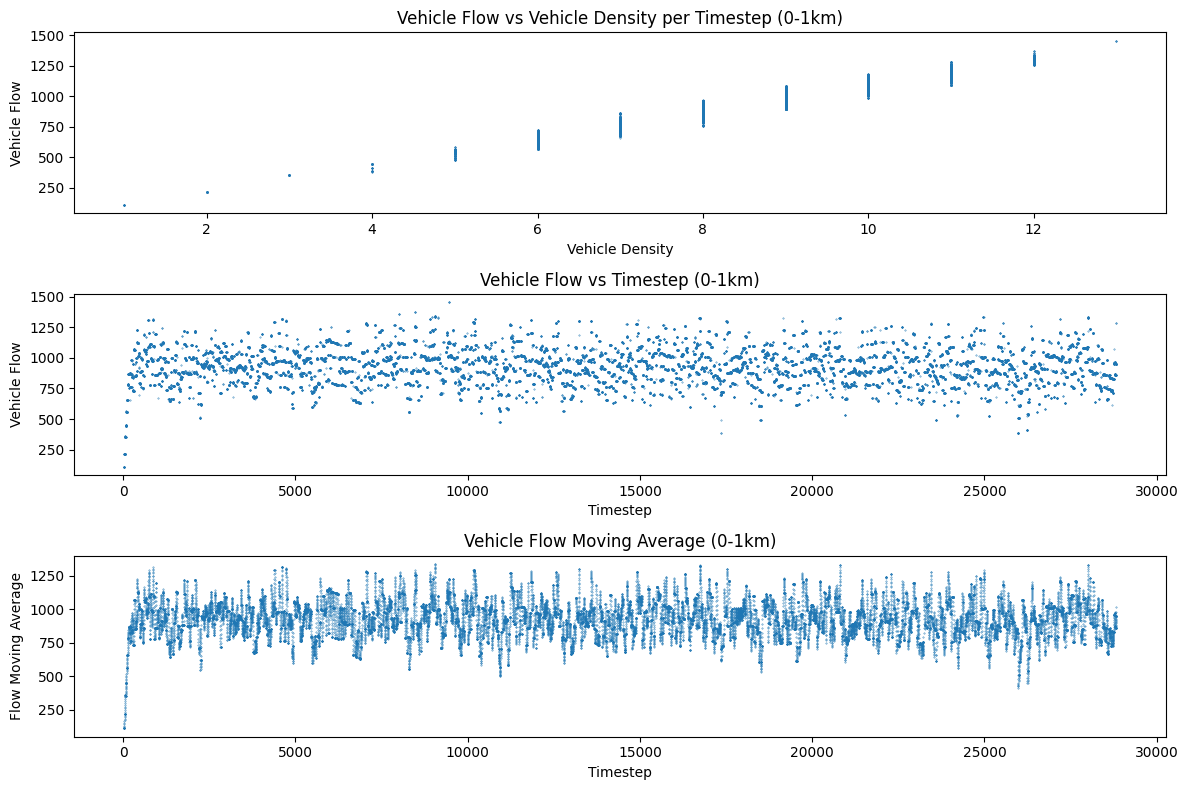

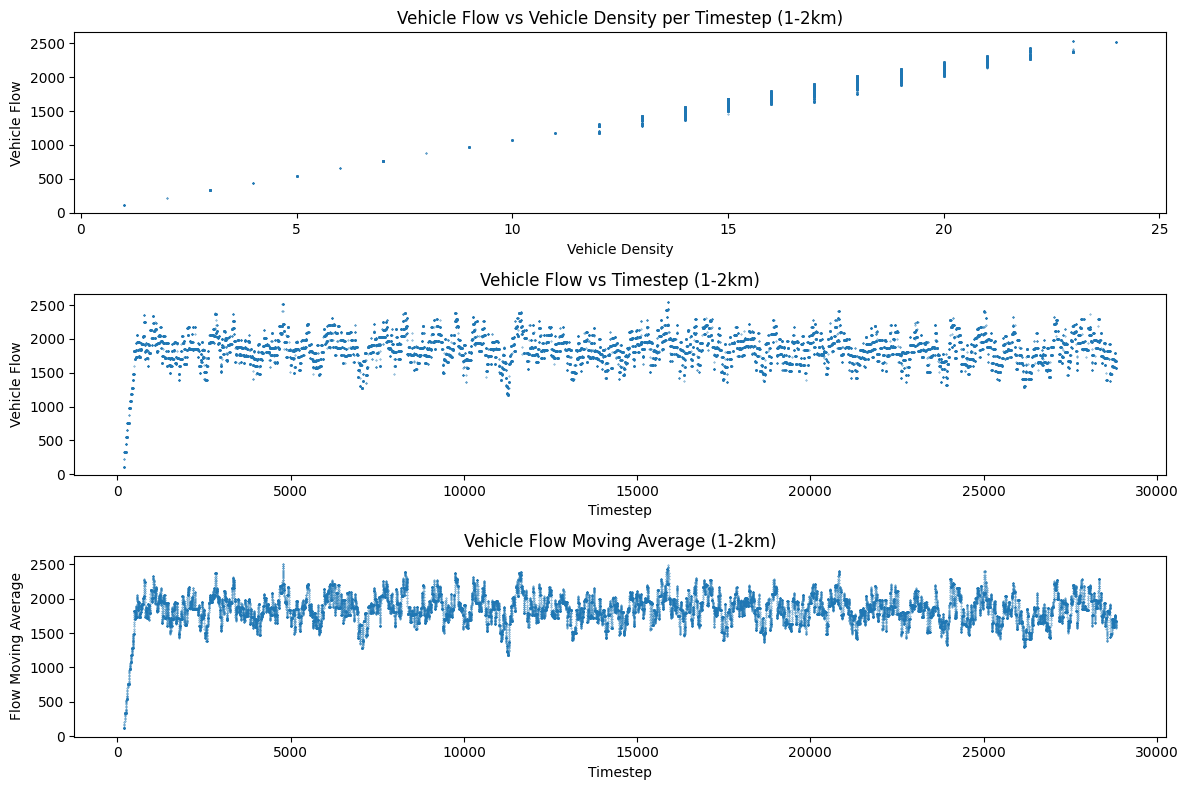

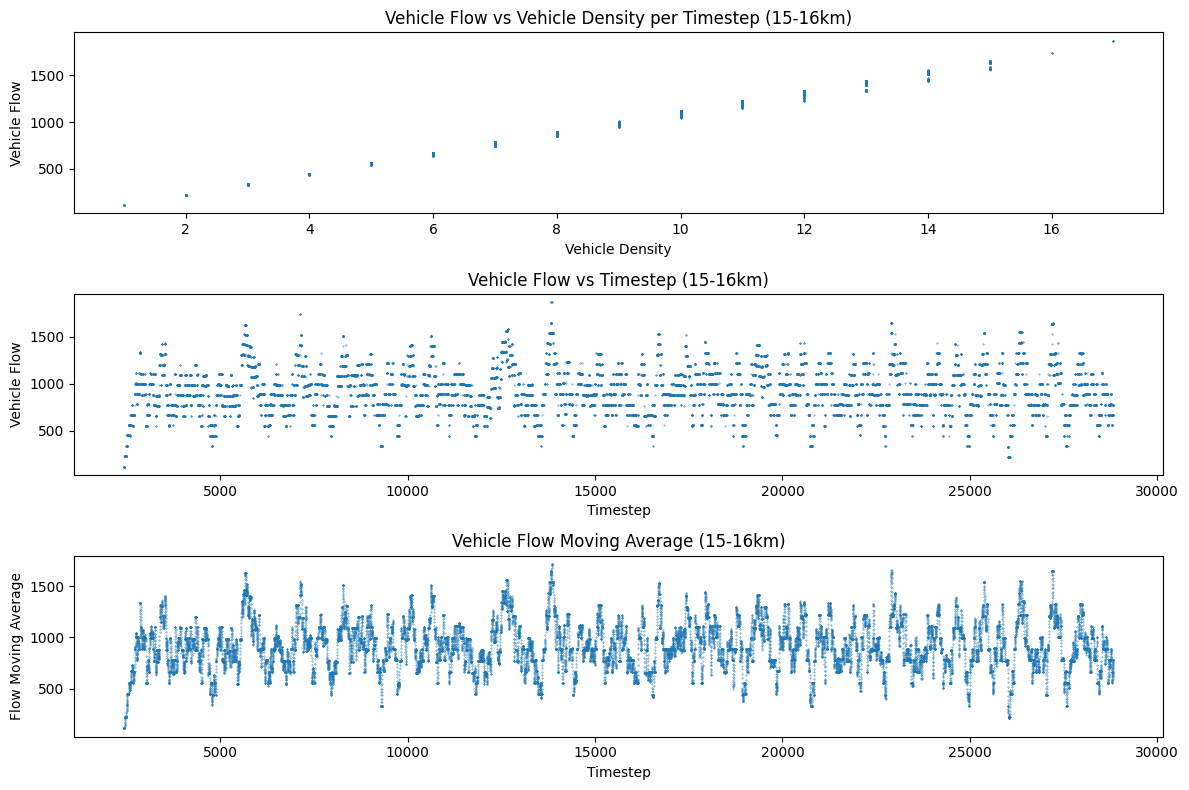

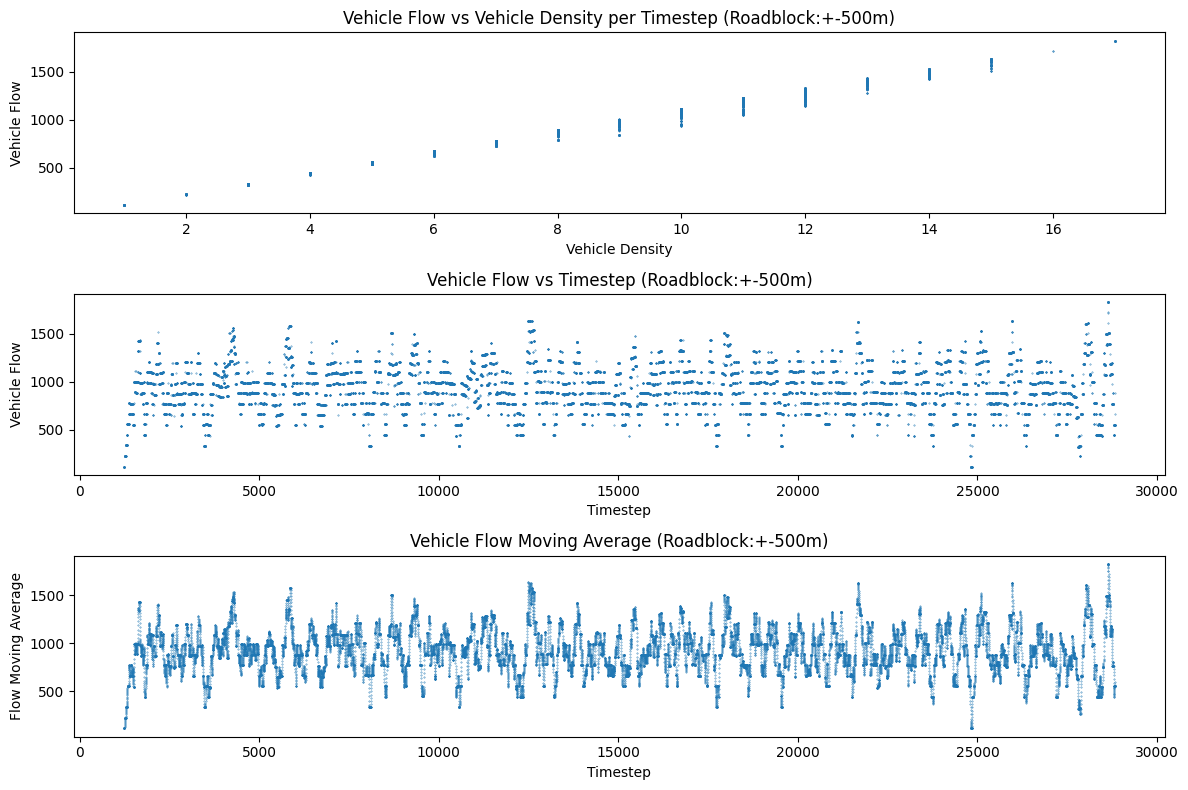

In [21]:
# Iterate over intervals and create separate plots
for interval_label, interval_df in grouped_df.groupby('Interval'):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3,1,1)
    plt.scatter(interval_df['num_vehicles'], interval_df['flow'], 0.1)
    plt.xlabel('Vehicle Density')
    plt.ylabel('Vehicle Flow')
    plt.title(f'Vehicle Flow vs Vehicle Density per Timestep ({interval_label})')
    
    plt.subplot(3,1,2)
    plt.scatter(interval_df['frame'], interval_df['flow'], 0.1)
    plt.xlabel('Timestep')
    plt.ylabel('Vehicle Flow')
    plt.title(f'Vehicle Flow vs Timestep ({interval_label})')
    
    plt.subplot(3,1,3)
    plt.scatter(interval_df['frame'], interval_df['moving_average_flow'], 0.1)
    plt.xlabel('Timestep')
    plt.ylabel('Flow Moving Average')
    plt.title(f'Vehicle Flow Moving Average ({interval_label})')
    
    plt.tight_layout()
    plt.show()

In [2]:


# Create an empty datafrmae to store the filtered rows
filtered_df = pd.DataFrame()

# Filter rows based on x-coordinate range
for label, (start, end) in testDict.items():
    interval_rows = df[df['location'].apply(lambda x: start <= x[0] <= end)]
    interval_rows['Interval'] = label  # Add a new column for interval label
    filtered_df = pd.concat([filtered_df, interval_rows])
    

# Reset the index of the combined DataFrame
filtered_df = filtered_df.reset_index(drop=True)

In [3]:
filtered_df.tail()

,frame,uuid,vehicle_type,location,speed,timestamp,Interval
1191234,28830,6a66e53a-9d60-44a1-93e5-7a4e9c237368,shc,"[31240.56923639822, 520]",61.483642,204377.098654,15-16km
1191235,28830,06c7b47a-9bae-47a5-bc45-95661a97173b,shc,"[30849.14953523976, 510]",61.396282,204377.098654,15-16km
1191236,28830,39ace4ad-d06c-4d08-b2ac-175d71483746,shc,"[31676.83926075097, 530]",62.063996,204377.098654,15-16km
1191237,28830,3e7c864f-4f71-4c38-801e-b84ff04d1a61,shc,"[30217.126444101694, 510]",60.964923,204377.098655,15-16km
1191238,28830,854366f7-3b13-4611-bda9-73b394695d3e,shc,"[30348.66786837051, 520]",61.819944,204377.098657,15-16km


In [4]:
# Converting pixel/second -> kmph
filtered_df['speed'] *= (3600 / 2000) # Converts back to kmph

# Group by frame and calculate necessary statistics
grouped_df = filtered_df.groupby('frame').agg({
    'speed': 'mean',
    'uuid': 'nunique'
}).reset_index()

# Rename columns for clarity
grouped_df.rename(columns={'speed': 'average_speed', 'uuid': 'num_vehicles'}, inplace=True)

In [5]:
grouped_df

,frame,average_speed,num_vehicles
0,17,109.027129,1
1,18,109.027129,1
2,19,109.040022,1
3,20,109.052872,1
4,21,109.065678,1
...,...,...,...
28809,28826,106.892589,36
28810,28827,106.887138,36
28811,28828,106.881762,36
28812,28829,107.353304,40


In [6]:
# Compute flow and moving average
grouped_df['flow'] = grouped_df['num_vehicles'] * grouped_df['average_speed']
grouped_df['moving_average_flow'] = grouped_df['flow'].rolling(window=10).mean()

# Drop rows with NaN values from rolling mean
grouped_df.dropna(subset=['moving_average_flow'], inplace=True)

# Convert columns to lists
num_vehicles = grouped_df['num_vehicles'].tolist()
flow = grouped_df['flow'].tolist()
moving_average_list = grouped_df['moving_average_flow'].tolist()

# # Plotting Data
# plt.figure(figsize=(12,8))

# # Plotting Vehicle Flow vs Vehicle Density
# plt.subplot(3,1,1)
# plt.scatter(num_vehicles, flow, 0.1)
# plt.xlabel('Vehicle Density (Vehicle/km)')
# plt.ylabel('Vehicle Flow (Vehicle/Hour)')
# plt.title(f"Vehicle Flow vs Vehicle Density from {label}")

# # Plotting Vehicle Flow vs Timestep
# plt.subplot(3,1,2)
# plt.scatter(range(len(flow)), flow, 0.1)
# plt.xlabel('Timestep')
# plt.ylabel('Vehicle Flow (Vehicle/Hour)')
# plt.title(f"Vehicle Flow vs Timestep from {label}")

# # Plotting Vehicle Flow Moving Average vs Timestep
# plt.subplot(3,1,3)
# plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
# plt.xlabel('Timestep')
# plt.ylabel('Flow Moving Average')
# plt.title(f"Plot of Vehicle Flow Moving Average from {label}")


# Iterate over intervals and create plots
for interval_label, interval_df in grouped_df.groupby('Interval'):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(interval_df['num_vehicles'], interval_df['flow'], marker='o', linestyle='-', color='b')
    plt.xlabel('Vehicle Density/Timestep')
    plt.ylabel('Vehicle Flow/Timestep')
    plt.title(f'Vehicle Flow vs Vehicle Density from ({interval_label})')
    
    plt.subplot(1, 3, 2)
    plt.plot(interval_df['frame'], interval_df['flow'], marker='o', linestyle='-', color='g')
    plt.xlabel('Timestep')
    plt.ylabel('Vehicle Flow')
    plt.title(f'Vehicle Flow vs Timestep ({interval_label})')
    
    plt.subplot(1, 3, 3)
    plt.plot(interval_df['frame'], interval_df['moving_average_flow'], marker='o', linestyle='-', color='r')
    plt.xlabel('Frame')
    plt.ylabel('Moving Average Flow')
    plt.title(f'Moving Average Flow vs Timestep ({interval_label})')
    
    plt.tight_layout()
    plt.show()

# plt.tight_layout()
# name = f"{filename}0-1km.png"
# save_name = name.replace("data/", "").replace(".json", "").replace("1000_vehicles/", "100_vehicles_")
# plt.savefig(save_name)

KeyError: 'Interval'